In [1]:
import numpy as np
import xarray as xr

import matplotlib.patches as patches
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
%matplotlib inline

import glob
import pandas as pd
import tarfile
from datetime import datetime, timedelta
from dateutil.parser import parse

import xroms
from xhistogram.xarray import histogram
from scipy import signal

#### Look at altimetry data processed from RADS http://rads.tudelft.nl/rads/data/authentication.cgi to identify seasonal variability

#### Unzip ascii files

In [2]:
def unzip_tar(filename, folder):
    data = tarfile.open(filename)
    data.extractall(folder) # specify which folder to extract to
    data.close()

filename = '/home/dylan/SUNRISE/Rads/Cryostat_New/radsdata.tar.gz' #Cryostat 2
folder = '/home/dylan/SUNRISE/Rads/Cryostat_New/'

unzip_tar(filename, folder)

#### Convert ascii files to pandas dataframe. 
Each file represents an individual sat. track so there are a few options how to deal with this. My thoughts are to (probably naively) have a list of dataframes, however you could probably write some code to assign an index to each track and then concatenate the dataframes. Although this way is good for practicing loops :)

In [3]:
def asc_to_pd(filenames):
    '''
Conver ascii files to pandas df. First, dates are parsed from the header because 
the files are formatted unideally. Types of each columns need to specified or
they will be classified as object.
---
Inputs: filenames - glob of file path
---
outputs: dfs - list of dataframes
    '''
    dfs = []

    for files in range(len(filenames)):
        #Parse the dates from the header - thanks Rob for the help
        with open(filenames[files]) as f:
            line = f.readline()
            line = f.readline()
            while line[0] == '#':
                variable, value = line.split('=')
                if variable == '# Satellite ':
                    satelite = value.strip()
                if variable == '# Equ_time  ':
                    datestr = value[value.find("(")+1:value.find(")")]
                    date = parse(datestr)
                line = f.readline()

            times = []; lats = []; lons = []; slas = []
            while line:
                time, lat, lon, sla = line.split()
                times.append(timedelta(seconds=float(time)) + date)
                lats.append(float(lat))
                lons.append(float(lon))
                slas.append(float(sla))
                line = f.readline()
                
            # Convert 
            time = np.array(times)
            lat = np.array(lats)
            lon = np.array(lons)
            sla = np.ma.array(slas, fill_value = 0, keep_mask = False)
            
            df = pd.DataFrame(data = [time, lat, lon, sla], 
                              index = ['time', 'lat', 'lon', 'sla']).T
            df.lat = df.lat.astype(float)
            df.lon = df.lon.astype(float)
            df.sla = df.sla.astype(float)
            
            #If you prefer xarray, this would be sample syntax.
#             d = df.to_xarray()
#             ds_sat = d.assign_coords(lat = d.lat, lon = d.lon, time = d.time)
#             ds_sat = ds_sat.drop('index')
#             ds_sat = ds_sat.rename({'index':'time'})
        
            dfs.append(df)
            
    return dfs

In [4]:
filenames = glob.glob('/home/dylan/SUNRISE/Rads/Cryostat_New/*.asc')
dfs = asc_to_pd(filenames)

#### Use TX-LA model output to identify cutoffs for the altimetry.
We will find the extrema of the latitudes between the 10 and 80 m isobaths. This is an imperfect method because the isobaths are very curved along the LA coast. Ideally - break the box up into several areas to increase accuracy, but this will do for now

In [5]:
path = '/d1/shared/TXLA_ROMS/output_20yr_obc/2010/ocean_his_00*.nc'
ds = xroms.xroms.open_netcdf(path, chunks = {'ocean_time':1})

ds, grid = xroms.xroms.roms_dataset(ds, Vtransform = None)

domain = ds.h.where((ds.lon_rho>-94.5) 
                     & (ds.lon_rho<-91.5) 
                     & (ds.h>10) 
                     & (ds.h<80),
                     drop = True)

latmin = domain.lat_rho.min().values
latmax = domain.lat_rho.max().values

print(latmin)
print(latmax)

dsbox = []
for files in range(len(dfs)):
    box = dfs[files].where((dfs[files].lon>-94.5) & (dfs[files].lon<-91.5) &
                       (dfs[files].lat>28) & (dfs[files].lat<(29.59)),
                        )
    
    box = box.dropna()
    if not box.empty:
        dsbox.append(box)
    

27.76408309703169
29.692119591067048


In [6]:
box1 = [item for item in dsbox if len(item.time)>25]  #arbitrary criteria to elimate short tracks
print(len(box1))

447


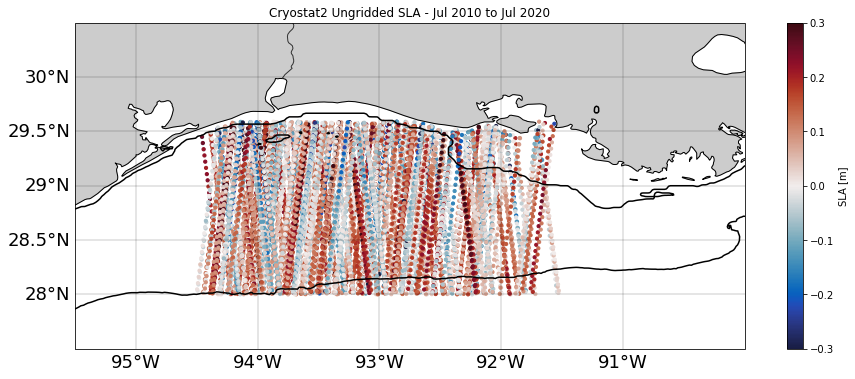

In [9]:
fig, ax = plt.subplots(1,1, figsize=(15,6),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-85.0)})

land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                edgecolor='face',
                                facecolor=cfeature.COLORS['land'])
states_provinces = cfeature.NaturalEarthFeature(
                   category='cultural',
                   name='admin_1_states_provinces_lines',
                   scale='10m',
                   facecolor='none')

hlevs = [10, 80]  # isobath contour depths
cs = ax.contour(ds.lon_rho, ds.lat_rho, ds.h, hlevs, colors = 'k', transform=ccrs.PlateCarree(), linewidths=1.5)
ax.tick_params(axis='y', labelsize=18)
# ax.clabel(cs, [10, 80], fontsize = 14, fmt = '%1.1f',inline = True)

for i in range(len(box1[:])):
    mappable = ax.scatter(box1[i].lon[:], box1[i].lat[:], c = box1[i].sla[:] ,
                          cmap = cmo.balance, 
                          transform = cartopy.crs.PlateCarree(),
                          vmin = -0.3, vmax = 0.3,
                          s = 10)
ax.set_title('Cryostat2 Ungridded SLA - Jul 2010 to Jul 2020')

ax.add_feature(land_10m, facecolor='0.8')
ax.coastlines(resolution='10m')  
ax.add_feature(states_provinces, edgecolor='0.2')
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='0.2')
ax.set_aspect('auto')

gl = ax.gridlines(linewidth=0.4, color='black', alpha=0.5, linestyle='-', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.top_labels = False

ax.set_extent([-95.5, -90, 27.5, 30.5], ccrs.PlateCarree())

cb = fig.colorbar(mappable, ax = ax, orientation='vertical', label = 'SLA [m]')
ax.set_aspect('auto')


plt.rcParams.update({'font.size': 18})

#### Plot basic lat lon variability

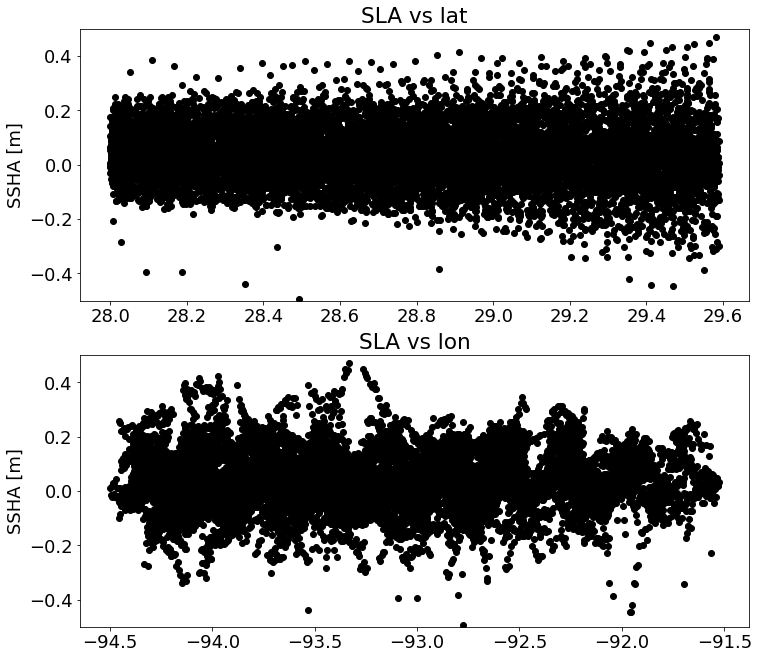

In [10]:
fig, ax = plt.subplots(2,1, figsize = (12,11))

for i in range(len(box1)):
    ax[0].scatter(box1[i].lat, box1[i].sla, color = 'k')
    ax[0].set_ylim(-0.5, 0.5)
    ax[0].set_ylabel('SSHA [m]')
#     ax[0].set_xlabel('Lat [$^{\circ}$]')
    ax[0].set_title('SLA vs lat')

    ax[1].scatter(box1[i].lon, box1[i].sla, color = 'k')
    ax[1].set_ylim(-0.5, 0.5)
    ax[1].set_ylabel('SSHA [m]')
#     ax[1].set_xlabel('Lon [$^{\circ}$]')
    ax[1].set_title('SLA vs lon')

#### Calculate season of each track

In [11]:
month_to_season_lu = np.array([
    None,
    'DJF', 'DJF',
    'MAM', 'MAM', 'MAM',
    'JJA', 'JJA', 'JJA',
    'SON', 'SON', 'SON',
    'DJF'
])

for i in range(len(box1)):
    grp_ary = month_to_season_lu[box1[i].time.dt.month]
    box1[i]['season'] = grp_ary
   

#### Group the tracks by JJA and DJF

In [12]:
JJA = []
DJF = []
for i in range(len(box1)):
    if (box1[i].season.iloc[0]=='JJA'):
        JJA.append(box1[i])
        
    if (box1[i].season.iloc[0]=='DJF'):
        DJF.append(box1[i])

#### Mean, standard deviation, and detrended tracks by season

In [13]:
boxstd = []
boxmean = []
    
for i in range(len(JJA)):
    std = np.std(JJA[i].sla)
    boxstd.append(std)
    mn = np.mean(JJA[i].sla)
    boxmean.append(mn)

stdJJA = np.asarray(boxstd)
meanJJA = np.asarray(boxmean)

boxstd = []
boxmean = []

for i in range(len(DJF)):
    std = np.std(DJF[i].sla)
    boxstd.append(std)
    mn = np.mean(DJF[i].sla)
    boxmean.append(mn)
    
stdDJF = np.asarray(boxstd)
meanDJF = np.asarray(boxmean)

boxstd = []
boxmean = []
JJAdt = []

for i in range(len(JJA)):
    dt = signal.detrend(JJA[i].sla)
    JJAdt.append(dt)
    std = np.std(dt)
    boxstd.append(std)
    mn = np.mean(dt)
    boxmean.append(mn)
   
stdJJAdt = np.asarray(boxstd)
meanJJAdt = np.asarray(boxmean)
JJAdt = np.asarray(JJAdt)

boxstd = []
boxmean = []
DJFdt = []
for i in range(len(DJF)):
    dt = signal.detrend(DJF[i].sla)
    DJFdt.append(dt)
    std = np.std(dt)
    boxstd.append(std)
    mn = np.mean(dt)
    boxmean.append(mn)
    
DJFdt = np.asarray(DJFdt)
stdDJFdt = np.asarray(boxstd)
meanDJFdt = np.asarray(boxmean)

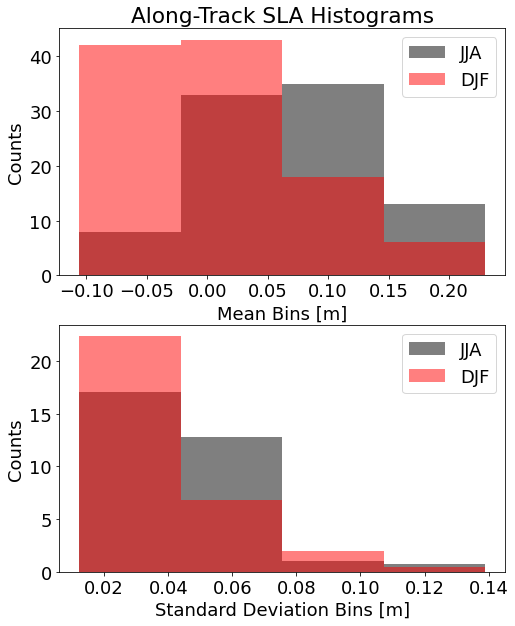

In [14]:
fig, ax = plt.subplots(2, figsize = (8, 10))

n, bins, hist = ax[0].hist(meanJJA, bins = 4, 
                           color = 'k', histtype='stepfilled',  alpha = 0.5, label = 'JJA')
ax[0].hist(meanDJF, bins = bins, 
            color = 'r', histtype='stepfilled', alpha = 0.5, label = 'DJF')
ax[0].legend()
ax[0].set_xlabel('Mean Bins [m]')
ax[0].set_ylabel('Counts')
ax[0].set_title('Along-Track SLA Histograms')

n, bins, hist = ax[1].hist(stdJJA, bins = 4, density = True, 
                           color = 'k', histtype='stepfilled', alpha = 0.5, label = 'JJA')
ax[1].hist(stdDJF, bins = bins, density = True, 
           color = 'r', histtype='stepfilled', alpha = 0.5, label = 'DJF')

ax[1].legend()
ax[1].set_xlabel('Standard Deviation Bins [m]')
ax[1].set_ylabel('Counts')

plt.rcParams.update({'font.size': 16})

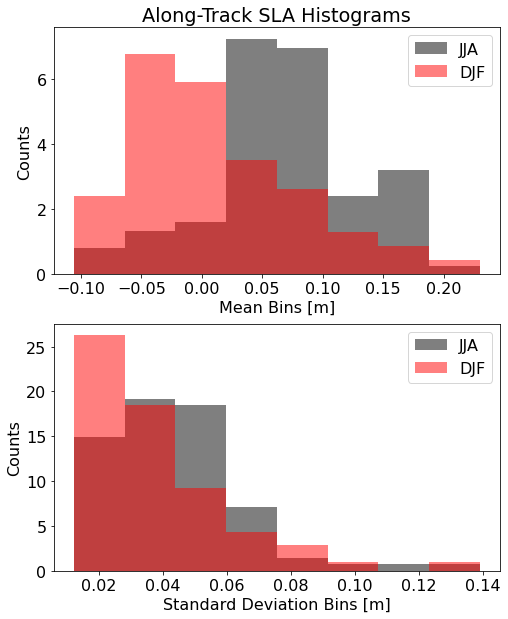

In [15]:
fig, ax = plt.subplots(2, figsize = (8, 10))

n, bins, hist = ax[0].hist(meanJJA, bins = 8, density = True, 
                           color = 'k', histtype='stepfilled',  alpha = 0.5, label = 'JJA')
ax[0].hist(meanDJF, bins = bins, density = True, 
           color = 'r', histtype='stepfilled', alpha = 0.5, label = 'DJF')
ax[0].legend()
ax[0].set_xlabel('Mean Bins [m]')
ax[0].set_ylabel('Counts')
ax[0].set_title('Along-Track SLA Histograms')

n, bins, hist = ax[1].hist(stdJJA, bins = 8, density = True, 
                           color = 'k', histtype='stepfilled', alpha = 0.5, label = 'JJA')
ax[1].hist(stdDJF, bins = bins, density = True, 
           color = 'r', histtype='stepfilled', alpha = 0.5, label = 'DJF')

ax[1].legend()
ax[1].set_xlabel('Standard Deviation Bins [m]')
ax[1].set_ylabel('Counts')

plt.rcParams.update({'font.size': 16})

Text(0.5, 1.0, 'Along-Track SLA Histograms')

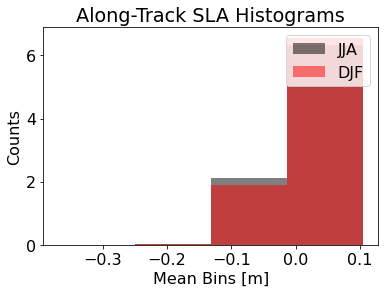

In [16]:
fig, ax = plt.subplots(1, figsize = (6, 4))

n, bins, hist = ax.hist(np.concatenate(JJAdt), bins = 4, density = True, 
                           color = 'k', histtype='stepfilled',  alpha = 0.5, label = 'JJA')
ax.hist(np.concatenate(DJFdt), bins = bins, density = True, 
           color = 'r', histtype='stepfilled', alpha = 0.5, label = 'DJF')
ax.legend()
ax.set_xlabel('Mean Bins [m]')
ax.set_ylabel('Counts')
ax.set_title('Along-Track SLA Histograms')

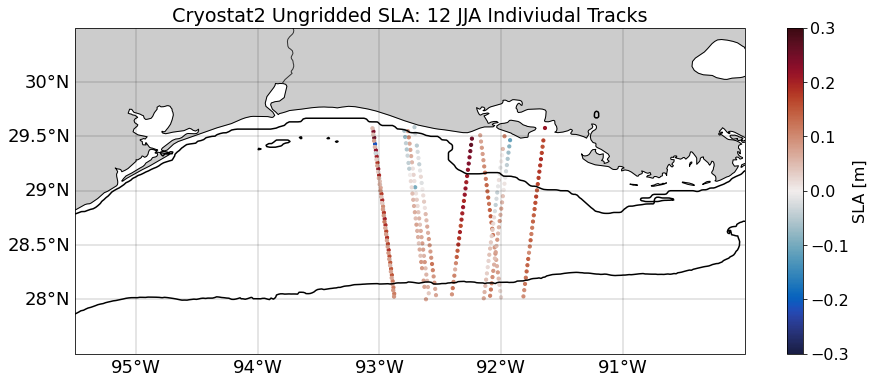

In [17]:
fig, ax = plt.subplots(1,1, figsize=(15,6),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-85.0)})

hlevs = [10, 80]  # isobath contour depths
cs = ax.contour(ds.lon_rho, ds.lat_rho, ds.h, hlevs, colors = 'k', transform=ccrs.PlateCarree(), linewidths=1.5)
ax.tick_params(axis='y', labelsize=18)
# ax.clabel(cs, [10, 80], fontsize = 14, fmt = '%1.1f',inline = True)

for i in range(len(JJA[1:12])):
    mappable = ax.scatter(JJA[i*2].lon[:], JJA[i*2].lat[:], c = JJA[i*2].sla[:] ,
                          cmap = cmo.balance, 
                          transform = cartopy.crs.PlateCarree(),
                          vmin = -0.3, vmax = 0.3,
                          s = 10)
ax.set_title('Cryostat2 Ungridded SLA: 12 JJA Indiviudal Tracks')

ax.add_feature(land_10m, facecolor='0.8')
ax.coastlines(resolution='10m')  
ax.add_feature(states_provinces, edgecolor='0.2')
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='0.2')
ax.set_aspect('auto')

gl = ax.gridlines(linewidth=0.4, color='black', alpha=0.5, linestyle='-', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.top_labels = False

ax.set_extent([-95.5, -90, 27.5, 30.5], ccrs.PlateCarree())

cb = fig.colorbar(mappable, ax = ax, orientation='vertical', label = 'SLA [m]')
ax.set_aspect('auto')


plt.rcParams.update({'font.size': 18})

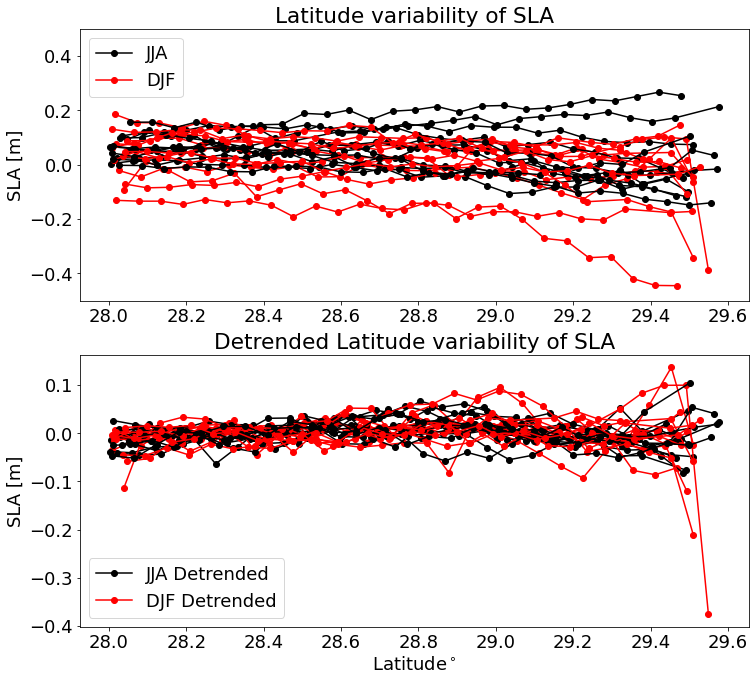

In [18]:
fig, ax = plt.subplots(2,1, figsize = (12,11))

for i in range(len(JJA[:12])):
    ax[0].plot(JJA[i].lat, JJA[i].sla, 'ko-')
    ax[0].plot(DJF[i].lat, DJF[i].sla,'ro-')
    ax[1].plot(JJA[i].lat, JJAdt[i], 'ko-')
    ax[1].plot(DJF[i].lat, DJFdt[i],'ro-')
    
ax[0].set_ylim(-0.5, 0.5)
ax[0].set_ylabel('SLA [m]')
# ax[0].set_xlabel('Latitude$^\circ$')
ax[0].set_title('Latitude variability of SLA')
ax[0].legend(['JJA','DJF'])

ax[1].set_ylabel('SLA [m]')
ax[1].set_xlabel('Latitude$^\circ$')
ax[1].set_title('Detrended Latitude variability of SLA')
ax[1].legend(['JJA Detrended','DJF Detrended'])

If you want to plot a histogram of the data, you will need to rerun this notebook but convert the dataframes to xarrray. 

In [ ]:
boxxr = xr.merge(box1)

lon_bins = np.linspace(-94.5, -91.5, 50)
lat_bins = np.linspace(28, 30.5, 50)

slah = histogram(boxxr.lon,boxxr.lat,
                 bins=[lon_bins, lat_bins],
                 weights=boxxr.sla**2)
norm = histogram(boxxr.lon,boxxr.lat,
                         bins=[lon_bins, lat_bins])
thresh =10
svar = slah / norm.where(norm > thresh)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15,6),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-85.0)})


mappable = svar.plot(y = 'lat_bin',
                      cmap = cmo.amp, 
                      transform = cartopy.crs.PlateCarree(),
                     
                      )
ax.set_title('Histogram of SLA Variance: Threshold 10 points/box')

ax.add_feature(land_10m, facecolor='0.8')
ax.coastlines(resolution='10m')  
ax.add_feature(states_provinces, edgecolor='0.2')
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='0.2')
ax.set_aspect('auto')

gl = ax.gridlines(linewidth=0.4, color='black', alpha=0.5, linestyle='-', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.top_labels = False

ax.set_extent([-95.5, -90, 28, 30.5], ccrs.PlateCarree())

# cb = fig.colorbar(mappable, ax = ax, orientation='vertical', label = 'SLA [m]')
# ax.set_aspect('auto')

plt.rcParams.update({'font.size': 18})